<a href="https://colab.research.google.com/github/tongrabbit/covidSentiment/blob/main/LSTM_89_coronavirus_tweets_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns 


from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


from sklearn.metrics import classification_report


import warnings
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/csv/Corona_NLP_test.csv',encoding='latin1')

test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/csv/Corona_NLP_test.csv',encoding='latin1')

# Combaine train and test set
df = train.append(test, ignore_index=True)

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         1668
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
df.Sentiment.value_counts()


Negative              2082
Positive              1894
Neutral               1238
Extremely Positive    1198
Extremely Negative    1184
Name: Sentiment, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7596 entries, 0 to 7595
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       7596 non-null   int64 
 1   ScreenName     7596 non-null   int64 
 2   Location       5928 non-null   object
 3   TweetAt        7596 non-null   object
 4   OriginalTweet  7596 non-null   object
 5   Sentiment      7596 non-null   object
dtypes: int64(2), object(4)
memory usage: 356.2+ KB


In [ ]:
# Convert sentiment into Positive = 2 , Neutral = 1 , Negative =  0
def convert_Sentiment(sentiment):
    if sentiment == "Extremely Positive":
        return 2
    elif sentiment == "Extremely Negative":
        return 0
    elif sentiment == "Positive":
        return 2
    elif sentiment == "Negative":
        return 0
    else:
        return 1

In [ ]:
# Apply convert_Sentiment function
df.Sentiment = df.Sentiment.apply(lambda x : convert_Sentiment(x))

0    3266
2    3092
1    1238
Name: Sentiment, dtype: int64
**********************************************************************


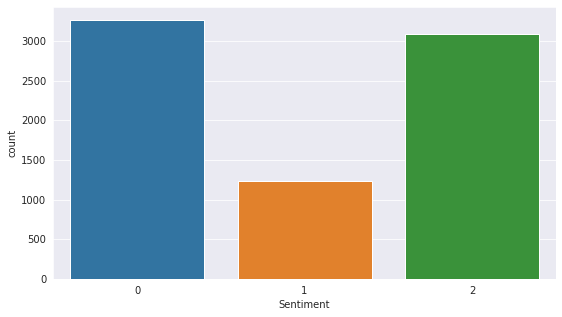

In [ ]:
# Visualize Sentiment
print(df.Sentiment.value_counts())
print('*' * 70)
plt.figure(figsize = (9,5)) 
sns.countplot(x = 'Sentiment',data = df)
plt.show()

In [ ]:
# Clean text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Apply functions on OriginalTweet
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_url(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_emoji(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : decontraction(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : char(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : x.lower())


In [ ]:
# Split sentiment groups 
Positive = df[df['Sentiment'] == 2].OriginalTweet
Neutral  = df[df['Sentiment'] == 1].OriginalTweet
Negative = df[df['Sentiment'] == 0].OriginalTweet


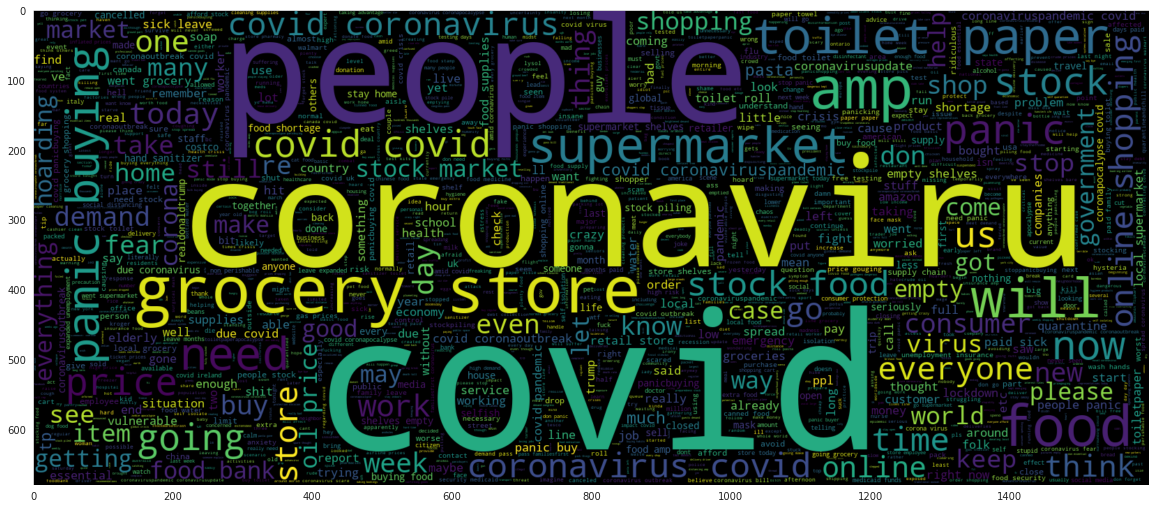

In [ ]:
# Worldcould of  Negative Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Negative))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

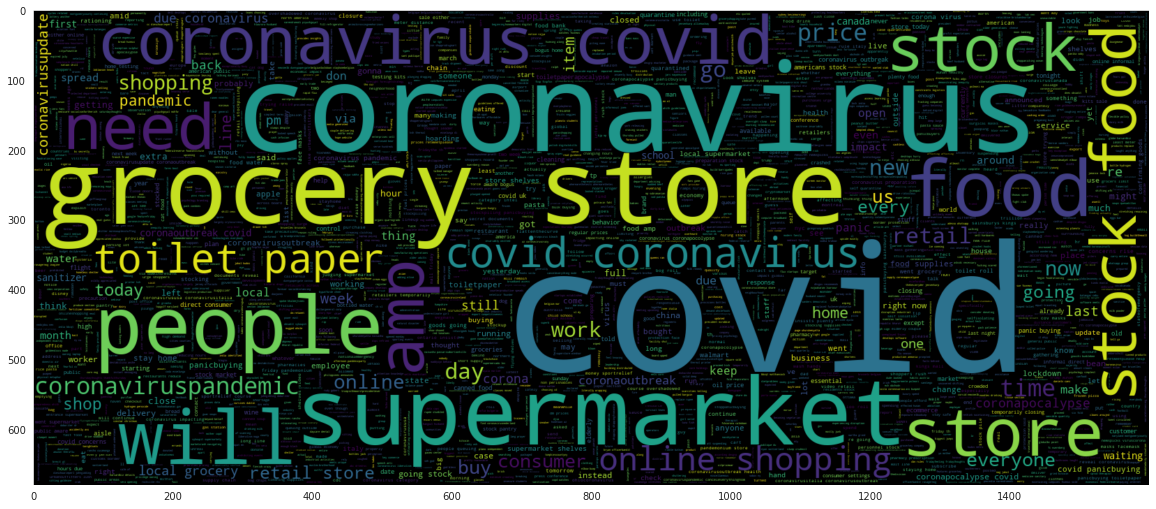

In [ ]:
# Wordcould of Neutral Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Neutral))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

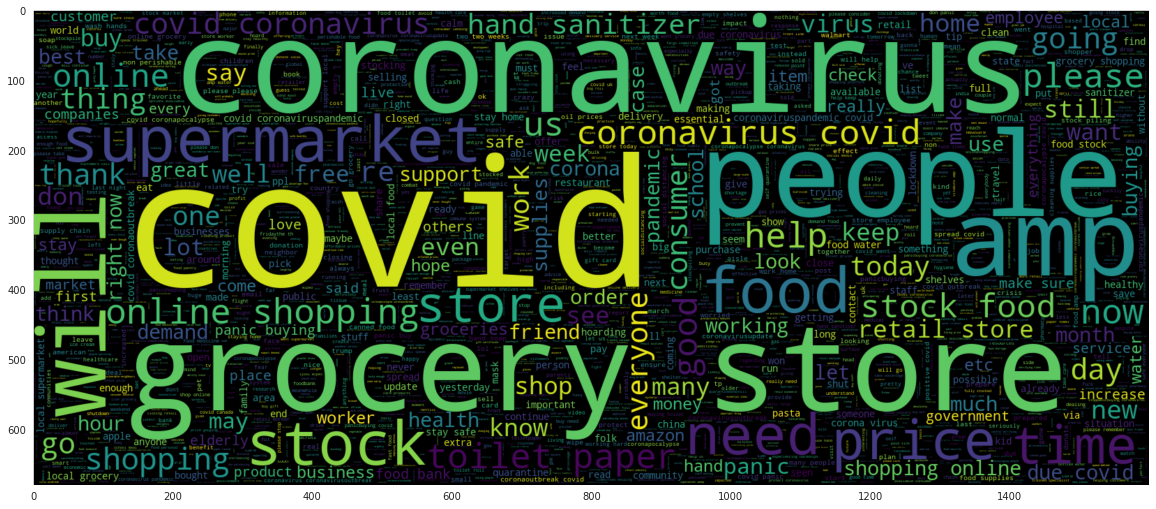

In [ ]:
# Wordcould of Positive Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Positive))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

In [ ]:
X = df['OriginalTweet']
y = df['Sentiment']

# Split data into train , test
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=0)


In [ ]:
y

0       0
1       2
2       2
3       0
4       1
       ..
7591    2
7592    0
7593    1
7594    0
7595    2
Name: Sentiment, Length: 7596, dtype: int64

In [ ]:
print('Shape of X_train : ' , X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of y_test : ',y_test.shape)

Shape of X_train :  (6076,)
Shape of y_train :  (6076,)
Shape of X_test :  (1520,)
Shape of y_test :  (1520,)


In [ ]:
# Convert y to categorical 
y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)


In [ ]:
y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
# Tokenize Texts
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# convert tokenized texts into same padding size
maxlen = 200
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)


In [ ]:
# Create Model  
inp = Input(shape=(maxlen, )) 
x   =  Embedding(max_features, embed_size)(inp)
x   =  LSTM(60, return_sequences=True,name='lstm_layer')(x)
x   =  GlobalMaxPool1D()(x)
x   =  Dense(64, activation="relu")(x)
x   =  Dropout(0.2)(x)
x   =  Dense(3, activation="softmax")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.fit(X_train_final,y_train, epochs=2,validation_data=(X_test_final,y_test))

Epoch 1/2
190/190 [==============================] - 36s 175ms/step - loss: 0.9021 - accuracy: 0.5431 - val_loss: 0.6431 - val_accuracy: 0.7375
Epoch 2/2
190/190 [==============================] - 32s 171ms/step - loss: 0.3569 - accuracy: 0.8749 - val_loss: 0.3565 - val_accuracy: 0.8691


In [ ]:
# Evaluate
model.evaluate(X_test_final,y_test)

48/48 [==============================] - 2s 33ms/step - loss: 0.3565 - accuracy: 0.8691


[0.3564963638782501, 0.8690789341926575]

In [ ]:
# Predict test
lstm_pred = np.round(model.predict(X_test_final))

In [ ]:
# Precision , Recall , F1-score
cr = classification_report(y_test,lstm_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       654
           1       0.84      0.84      0.84       263
           2       0.88      0.89      0.88       603

   micro avg       0.88      0.86      0.87      1520
   macro avg       0.87      0.86      0.86      1520
weighted avg       0.88      0.86      0.87      1520
 samples avg       0.86      0.86      0.86      1520

